## Customer Model with Reduced Features
---

With Customer Risk model feature outgrowning machine size, let's find ways to circumvent this issue.

In the previous notebook 4.3, we listed 4 options
* break data by chunks
* sample ids
* build model with reduced features
* switch to distributed computing

Let's address option 3 here.

A couple variations
* with/without indeterminate
* old/new indeterminate
* monotonic constraints
* weighing by indeterminate classes...


In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

### Data
---

In [2]:
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_scored.parquet"))

<AxesSubplot:>

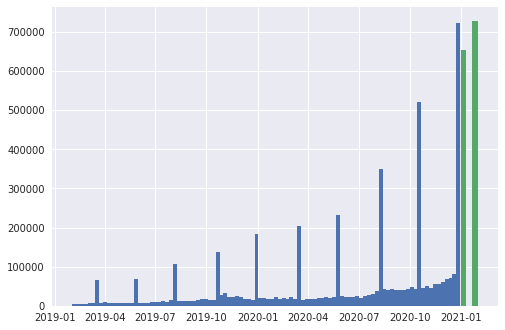

In [3]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=3)

In [4]:
train_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.598379
        True             0.364380
True    False            0.028351
        True             0.008890
dtype: float64

In [5]:
train_df.indeterminate.value_counts()

False    2918532
True     1738226
Name: indeterminate, dtype: int64

In [6]:
train_df.target.value_counts(normalize=True), test_df.target.value_counts(normalize=True)

(False    0.962759
 True     0.037241
 Name: target, dtype: float64,
 False    0.992724
 True     0.007276
 Name: target, dtype: float64)

### Select Features
---

In [7]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score',  # giact_time_since_last_link removed 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    # df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [8]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

### Refit
---

In [24]:
def train(modeling_df,
          features,
          date_col="sample_date", 
          indeterminate_col="indeterminate",
          params=None,
          targets = [{'target_col_name': 'target'}]):
    """
    Train and save model.
    """
    print("NUM FEATURES: ", len(features))
    targ_cols = []
    for t in targets:
        targ_cols.extend(t.values())
    
    other_cols = []
    if indeterminate_col is not None:
        other_cols.append(indeterminate_col)
    if date_col is not None:
        other_cols.append(date_col)
        
    modeling_df = modeling_df.copy()
    
    if indeterminate_col in modeling_df.columns:
        print("data statistics", modeling_df.shape)
        print("indeterminate removed!")
        modeling_df = modeling_df[~modeling_df[indeterminate_col]]
        print("data statistics after removing indeterminate", modeling_df.shape)
        
    
    modeling_df = preprocess(modeling_df)
    print(f"modeling_df last date: {modeling_df[date_col].max()}")
    

    print(targets)
    for target_definion in targets:
        target_col_name = target_definion['target_col_name']
        if 'ind_col_name' in target_definion:
            ind_col_name = target_definion['ind_col_name']
        else:
            ind_col_name = None
        
        if ind_col_name:
            mdf = modeling_df[~modeling_df[ind_col_name]]
        else:
            mdf = modeling_df.copy()
            
        print("target counts")
        print(mdf[target_col_name].value_counts())
        
        count_pos = mdf[target_col_name].sum()
        count_neg = (~mdf[target_col_name]).sum()
        pos_wgt_scaling_factor = count_neg / count_pos
        
        params['scale_pos_weight'] = pos_wgt_scaling_factor
        
        X = mdf[features]
        y = mdf[target_col_name]
    
        clf = lgb.LGBMClassifier(**params)
        clf = clf.fit(X, y)
        
    
    return clf

In [25]:
seed = 15556
print(seed)
    
scale_by_bad_rate = False
indeterminate_col = "indeterminate" # "indeterminate"  or None

params = {
        "objective" : "binary",
        "metric" : "auc",
        "boosting": 'gbdt',
        "num_iterations": 1400,  # 1400, 200
        "max_depth" : 4,
        "num_leaves" : 15,
        "learning_rate" : 0.03,
        "feature_fraction" : 0.8,
        "subsample": 0.94,
        "lambda_l1": 16,
        "lambda_l2": 10,
        "min_data_in_leaf": 116,
        "tree_learner": "feature",
        "bagging_seed" : seed,
        "verbosity" : 1,
        "seed": seed,
        "categorical_feature": None # need to find the current indices
    }

15556


In [27]:
# features to keep
cols_raw_reduced = ['address_risk_score',
 'age_money_account',
 'all7120',
 'all8220',
 'bcc7120',
 'credit_card_loan_amount',
 'dollar_val_dd',
 'dollar_val_returns',
 'education_loan_amount',
 'email_risk_score',
 'first_deposit_amount',
 'fraud_score_1',
 'fraud_score_2',
 'giact_nr_decline',
 'giact_nr_other',
 'iln5520',
 'iqt9413',
 'iqt9415',
 'lag_acc_open_first_transaction',
 'name_address_correlation',
 'name_email_correlation',
 'name_phone_correlation',
 'nr_direct_deposits',
 'nr_past_transactions',
 'pct_returned_deposits',
 'phone_risk_score',
 'time_since_last_transaction',
 'total_tradelines_open',
 'transaction_as_pct_of_balance',
 'vantage_score']

# removed 30+ d features
fts_30d = ["max_deposits_30d", "mean_account_balance_30d", "nr_trans_ratio", 
           "bal_ratio", "max_withdrawals_30d", "nr_returns_30d"]

# remove 10+ d features
fts_10d = ["sum_deposits_10d"]
    
# remove 3+ d features - no window rollup features
fts_3d = ["dollar_val_returns_3d"]

cols_encoded_reduced = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']


In [47]:
# exclude 30d
mname = "rm_30d_features"
features_reduced_rm30 = cols_raw_reduced + cols_encoded_reduced + fts_10d + fts_3d
categorical_indices = [features_reduced_rm30.index(c) for c in cols_encoded_reduced]
print(categorical_indices)
params["categorical_feature"] = categorical_indices
model_reduced_rm30 = train(train_df, features_reduced_rm30, date_col="sample_date", 
                      indeterminate_col="indeterminate", params=params)
info = {"model_name": mname,
        "params": params,
        "scale_by_bad_rate": scale_by_bad_rate,
        "features": features_reduced_rm30,
        "indeterminate_col": indeterminate_col}

with open("./artifacts/meta_data_rm30.json", "w") as f:
    json.dump(info, f, indent=4)
    
display(info)

# exclude 10+d
mname = "rm_10+d_features"
features_reduced_rm10 = cols_raw_reduced + cols_encoded_reduced + fts_3d
categorical_indices = [features_reduced_rm10.index(c) for c in cols_encoded_reduced]
print(categorical_indices)
params["categorical_feature"] = categorical_indices
model_reduced_rm10 = train(train_df, features_reduced_rm10, date_col="sample_date", 
                      indeterminate_col="indeterminate", params=params)
info = {"model_name": mname,
        "params": params,
        "scale_by_bad_rate": scale_by_bad_rate,
        "features": features_reduced_rm10,
        "indeterminate_col": indeterminate_col}

with open("./artifacts/meta_data_rm10.json", "w") as f:
    json.dump(info, f, indent=4)
    
display(info)

# exclude 3+d
mname = "rm_3+d_features"
features_reduced_rm3 = cols_raw_reduced + cols_encoded_reduced 
categorical_indices = [features_reduced_rm3.index(c) for c in cols_encoded_reduced]
print(categorical_indices)
params["categorical_feature"] = categorical_indices
model_reduced_rm3 = train(train_df, features_reduced_rm3, date_col="sample_date", 
                      indeterminate_col="indeterminate", params=params)
info = {"model_name": mname,
        "params": params,
        "scale_by_bad_rate": scale_by_bad_rate,
        "features": features_reduced_rm3,
        "indeterminate_col": indeterminate_col}

with open("./artifacts/meta_data_rm3.json", "w") as f:
    json.dump(info, f, indent=4)
    
display(info)

[30, 31, 32]
NUM FEATURES:  35
data statistics (4656758, 95)
indeterminate removed!
data statistics after removing indeterminate (2918532, 95)
modeling_df last date: 2020-12-31 00:00:00
[{'target_col_name': 'target'}]
target counts
False    2786508
True      132024
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boo

{'model_name': 'rm_30d_features',
 'params': {'objective': 'binary',
  'metric': 'auc',
  'boosting': 'gbdt',
  'num_iterations': 1400,
  'max_depth': 4,
  'num_leaves': 15,
  'learning_rate': 0.03,
  'feature_fraction': 0.8,
  'subsample': 0.94,
  'lambda_l1': 16,
  'lambda_l2': 10,
  'min_data_in_leaf': 116,
  'tree_learner': 'feature',
  'bagging_seed': 15556,
  'verbosity': 1,
  'seed': 15556,
  'categorical_feature': [30, 31, 32],
  'scale_pos_weight': 21.10607162334121},
 'scale_by_bad_rate': False,
 'features': ['address_risk_score',
  'age_money_account',
  'all7120',
  'all8220',
  'bcc7120',
  'credit_card_loan_amount',
  'dollar_val_dd',
  'dollar_val_returns',
  'education_loan_amount',
  'email_risk_score',
  'first_deposit_amount',
  'fraud_score_1',
  'fraud_score_2',
  'giact_nr_decline',
  'giact_nr_other',
  'iln5520',
  'iqt9413',
  'iqt9415',
  'lag_acc_open_first_transaction',
  'name_address_correlation',
  'name_email_correlation',
  'name_phone_correlation',
  '

[30, 31, 32]
NUM FEATURES:  34
data statistics (4656758, 95)
indeterminate removed!
data statistics after removing indeterminate (2918532, 95)
modeling_df last date: 2020-12-31 00:00:00
[{'target_col_name': 'target'}]
target counts
False    2786508
True      132024
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met categorical feature which contains 

{'model_name': 'rm_10+d_features',
 'params': {'objective': 'binary',
  'metric': 'auc',
  'boosting': 'gbdt',
  'num_iterations': 1400,
  'max_depth': 4,
  'num_leaves': 15,
  'learning_rate': 0.03,
  'feature_fraction': 0.8,
  'subsample': 0.94,
  'lambda_l1': 16,
  'lambda_l2': 10,
  'min_data_in_leaf': 116,
  'tree_learner': 'feature',
  'bagging_seed': 15556,
  'verbosity': 1,
  'seed': 15556,
  'categorical_feature': [30, 31, 32],
  'scale_pos_weight': 21.10607162334121},
 'scale_by_bad_rate': False,
 'features': ['address_risk_score',
  'age_money_account',
  'all7120',
  'all8220',
  'bcc7120',
  'credit_card_loan_amount',
  'dollar_val_dd',
  'dollar_val_returns',
  'education_loan_amount',
  'email_risk_score',
  'first_deposit_amount',
  'fraud_score_1',
  'fraud_score_2',
  'giact_nr_decline',
  'giact_nr_other',
  'iln5520',
  'iqt9413',
  'iqt9415',
  'lag_acc_open_first_transaction',
  'name_address_correlation',
  'name_email_correlation',
  'name_phone_correlation',
  

[30, 31, 32]
NUM FEATURES:  33
data statistics (4656758, 95)
indeterminate removed!
data statistics after removing indeterminate (2918532, 95)
modeling_df last date: 2020-12-31 00:00:00
[{'target_col_name': 'target'}]
target counts
False    2786508
True      132024
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boo

{'model_name': 'rm_3+d_features',
 'params': {'objective': 'binary',
  'metric': 'auc',
  'boosting': 'gbdt',
  'num_iterations': 1400,
  'max_depth': 4,
  'num_leaves': 15,
  'learning_rate': 0.03,
  'feature_fraction': 0.8,
  'subsample': 0.94,
  'lambda_l1': 16,
  'lambda_l2': 10,
  'min_data_in_leaf': 116,
  'tree_learner': 'feature',
  'bagging_seed': 15556,
  'verbosity': 1,
  'seed': 15556,
  'categorical_feature': [30, 31, 32],
  'scale_pos_weight': 21.10607162334121},
 'scale_by_bad_rate': False,
 'features': ['address_risk_score',
  'age_money_account',
  'all7120',
  'all8220',
  'bcc7120',
  'credit_card_loan_amount',
  'dollar_val_dd',
  'dollar_val_returns',
  'education_loan_amount',
  'email_risk_score',
  'first_deposit_amount',
  'fraud_score_1',
  'fraud_score_2',
  'giact_nr_decline',
  'giact_nr_other',
  'iln5520',
  'iqt9413',
  'iqt9415',
  'lag_acc_open_first_transaction',
  'name_address_correlation',
  'name_email_correlation',
  'name_phone_correlation',
  '

In [48]:
model_reduced_rm30, model_reduced_rm10, model_reduced_rm3

(LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[30, 31, 32], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=21.10607162334121, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[30, 31, 32], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=21.10607162334121, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical

In [49]:
with open("../../artifacts/20210508-reduced-features/customer_risk_rm30.pkl", "wb") as f:
    pkl.dump(model_reduced_rm30, f)

with open("../../artifacts/20210508-reduced-features/customer_risk_rm10.pkl", "wb") as f:
    pkl.dump(model_reduced_rm10, f)
    
with open("../../artifacts/20210508-reduced-features/customer_risk_rm3.pkl", "wb") as f:
    pkl.dump(model_reduced_rm3, f)

In [50]:
# produce active indicator
# had transactions in the past 30 days
# test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [51]:
print(len(features_reduced_rm30))
test_df["pred_reduced_rm30"] = model_reduced_rm30.predict_proba(test_df[features_reduced_rm30])[:,1]
test_df["score_reduced_rm30"] = mu.scale_scores(test_df["pred_reduced_rm30"])

print(len(features_reduced_rm10))
test_df["pred_reduced_rm10"] = model_reduced_rm10.predict_proba(test_df[features_reduced_rm10])[:,1]
test_df["score_reduced_rm10"] = mu.scale_scores(test_df["pred_reduced_rm10"])

print(len(features_reduced_rm3))
test_df["pred_reduced_rm3"] = model_reduced_rm3.predict_proba(test_df[features_reduced_rm3])[:,1]
test_df["score_reduced_rm3"] = mu.scale_scores(test_df["pred_reduced_rm3"])

pred_cols = ["score_incumbent", "score_wo_ind",
             "score_reduced_rm30", "score_reduced_rm10", "score_reduced_rm3"]

35
34
33


### Model Result
---

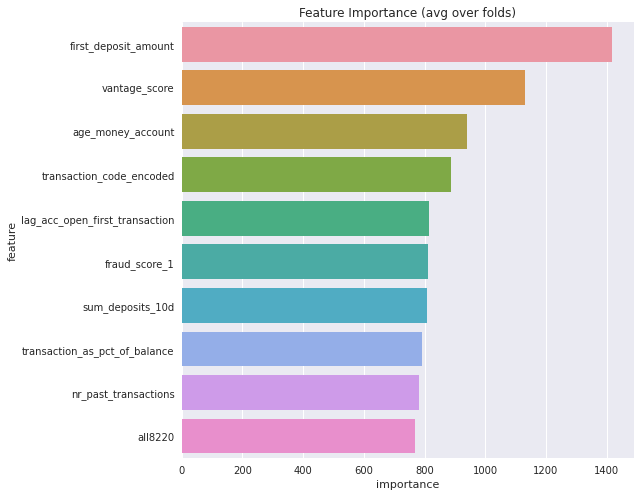

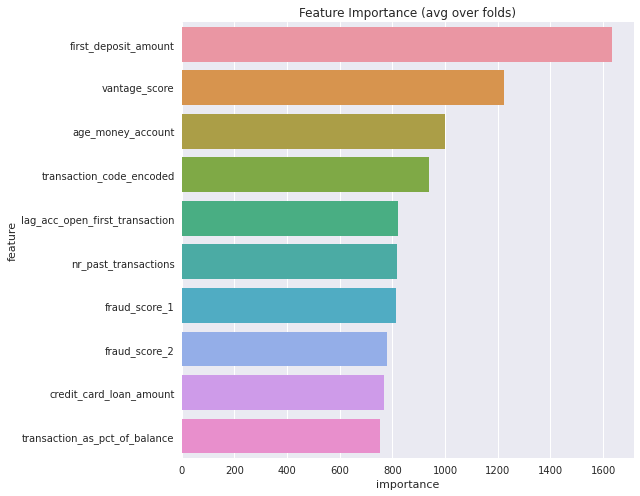

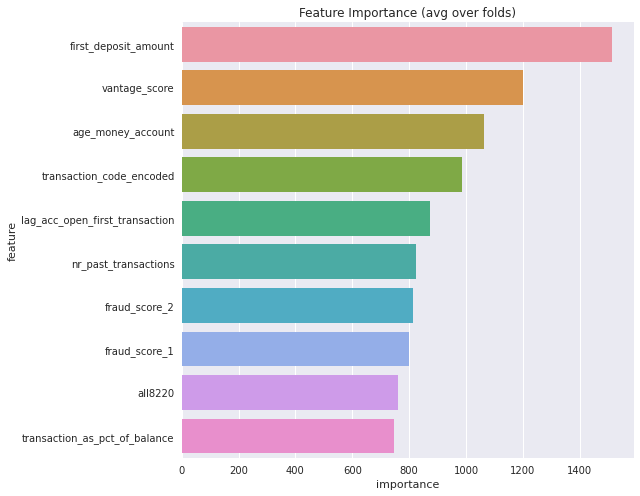

In [52]:
from rdsutils.plot.feature_importance import display_feature_importance

for m in [model_reduced_rm30, model_reduced_rm10, model_reduced_rm3]:
    fts = m.feature_name_
    fimps = m.feature_importances_
    display_feature_importance(fts, fimps, max_n_features=10)
    plt.show()

In [53]:
df_ = test_df # test_df[test_df.is_active]

In [54]:
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
report

,auc,ap,ks
score_incumbent,67.98,10.13,22.69
score_wo_ind,76.83,17.23,37.86
score_reduced_rm30,75.80,6.44,34.44
score_reduced_rm10,76.49,7.23,36.15
score_reduced_rm3,76.35,6.30,35.33


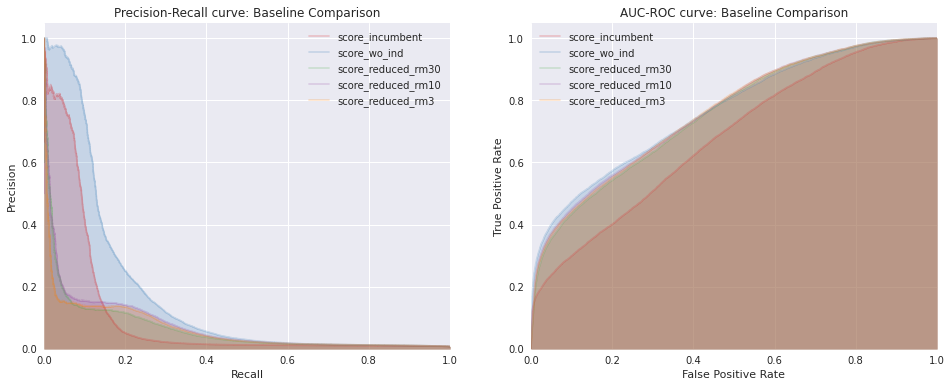

In [55]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"reduced": df_}, "target", pred_cols, mntr_path, dropna=True
    )

Model performance drops significantly if we drop the features. May consider keeping the features and modify the code.

(1381296, 112)

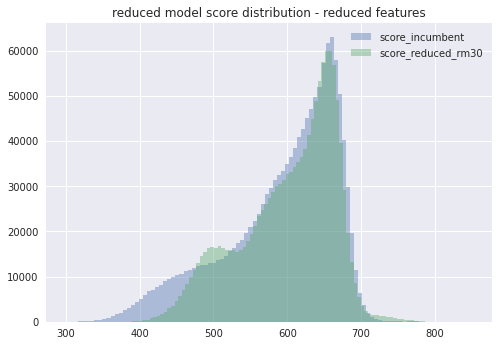

In [56]:
display(df_.shape)

score_col = "score_incumbent"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_reduced_rm30"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)


plt.title("reduced model score distribution - reduced features")
plt.legend()

In [57]:
def plot_score_distr(df, score1, score2, ax, title):

    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)
    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    
    ax.set_title(title)
    ax.legend()

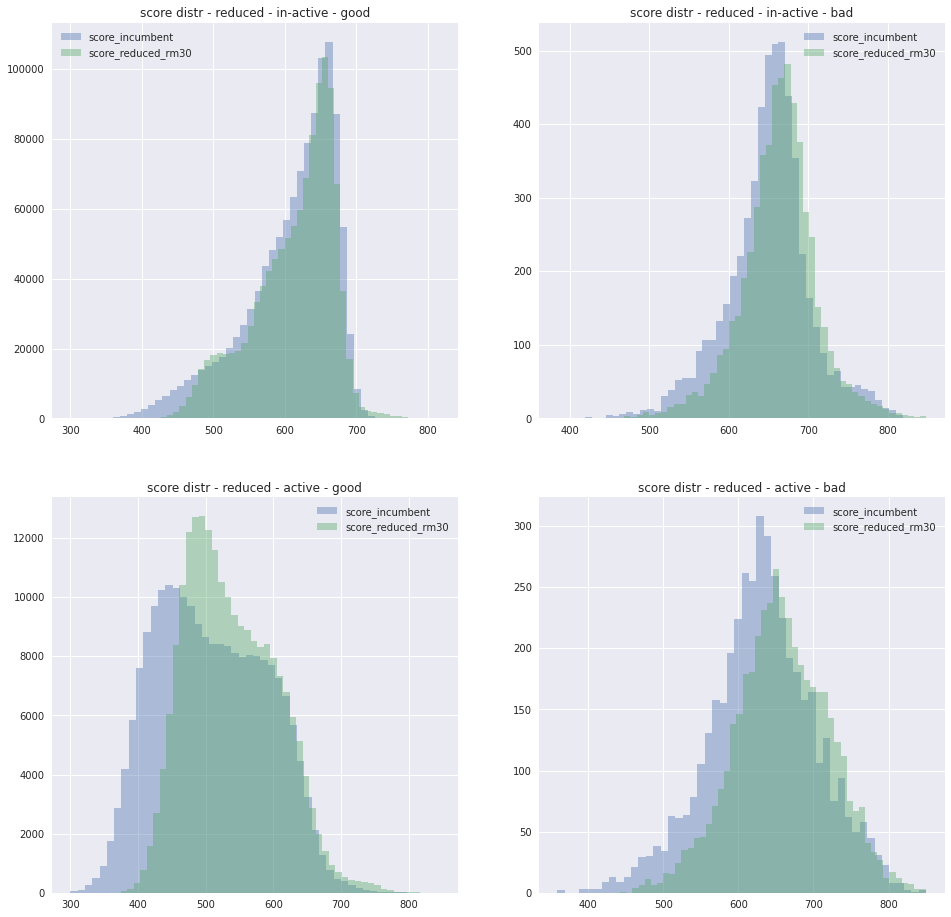

In [58]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_reduced_rm30"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, score1, score2, axs[0, 0], "score distr - reduced - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, score1, score2, axs[0, 1], "score distr - reduced - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, score1, score2, axs[1, 0], "score distr - reduced - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, score1, score2, axs[1, 1], "score distr - reduced - active - bad")

plt.show()

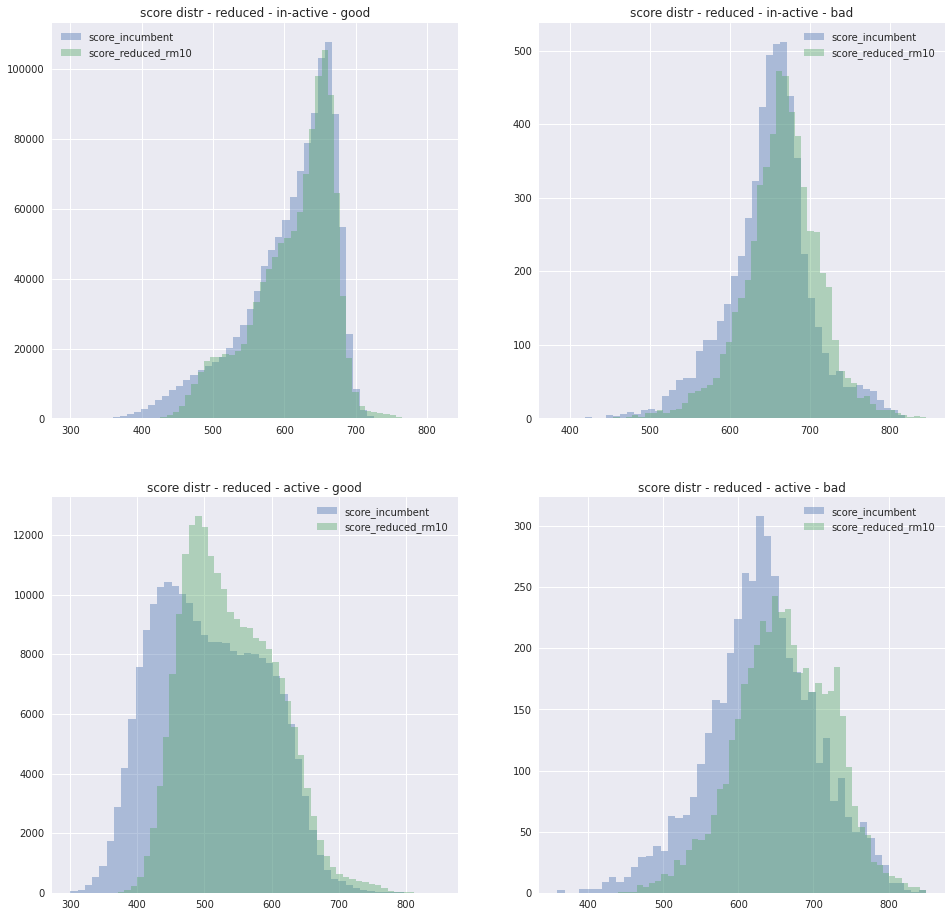

In [59]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_reduced_rm10"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, score1, score2, axs[0, 0], "score distr - reduced - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, score1, score2, axs[0, 1], "score distr - reduced - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, score1, score2, axs[1, 0], "score distr - reduced - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, score1, score2, axs[1, 1], "score distr - reduced - active - bad")

plt.show()

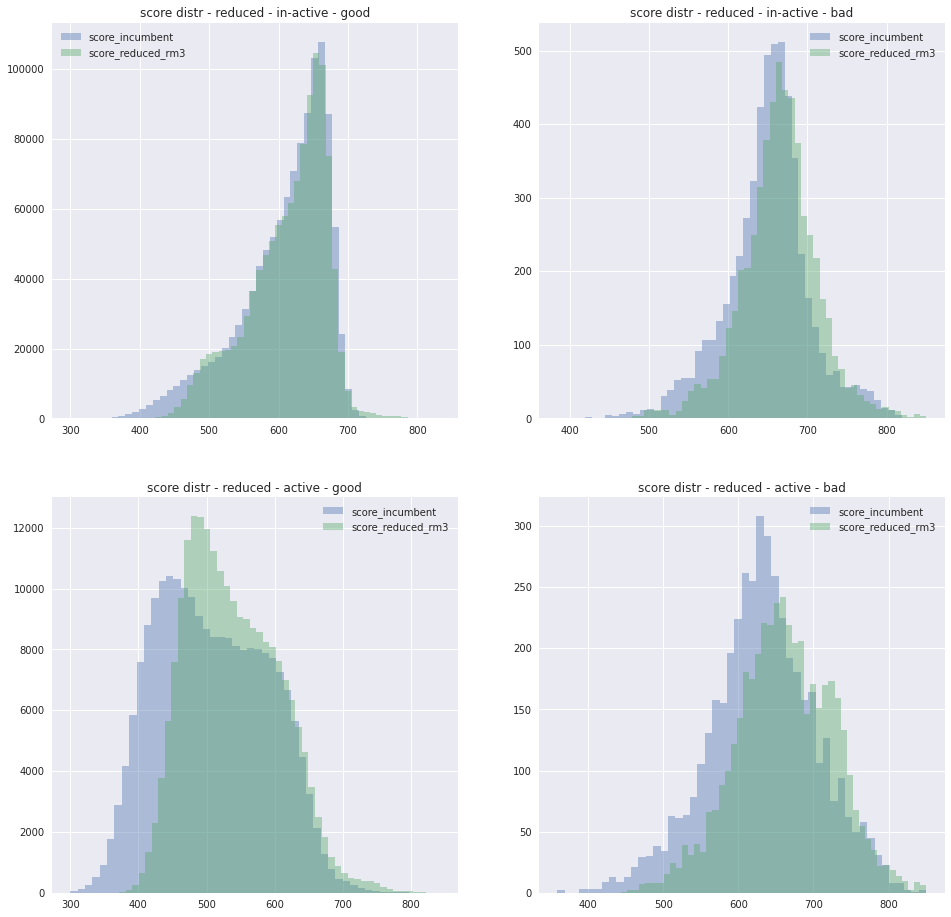

In [62]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_reduced_rm3"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, score1, score2, axs[0, 0], "score distr - reduced - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, score1, score2, axs[0, 1], "score distr - reduced - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, score1, score2, axs[1, 0], "score distr - reduced - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, score1, score2, axs[1, 1], "score distr - reduced - active - bad")

plt.show()